# Nearest neigbor aggregation
instead of full NEB paths

In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


In [3]:
import corc.complex_datasets
import corc.graph_metrics.neb
import studenttmixture
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sklearn
import corc.graph_metrics.tmm_gmm_neb
import jax.numpy as jnp
import corc.studentmixture

In [123]:
# dataset_name="densired"
dataset_name="densired_soft"
X,y = corc.complex_datasets.load_densired(8, path=f"../datasets/{dataset_name}.npz")
transformed_points = corc.utils.get_TSNE_embedding(X)


In [118]:
def predict_by_joining_closest_clusters(centers, y_pred, num_classes):

    def find_root(mapping, class_index):
        if mapping[class_index] != class_index:
            mapping[class_index] = find_root(mapping, mapping[class_index])
        return mapping[class_index]

    def merge_classes(mapping, class_i, class_j):
        root_i = find_root(mapping, class_i)
        root_j = find_root(mapping, class_j)
        
        # Merge by attaching root_j to root_i
        if root_i != root_j:
            mapping[root_j] = root_i
        return mapping

    mapping = np.array(range(len(centers)))

    distances = np.ones((len(centers),len(centers))) * np.inf
    for i in range(len(centers)):
        for j in range(i+1, len(centers)):
            if i!=j:
                distances[i,j] = np.linalg.norm(centers[i] - centers[j])
    
    num_classes_to_join = len(centers) - num_classes
    for _ in range(num_classes_to_join):
        i,j = np.unravel_index(np.argmin(distances), distances.shape)
        mapping = merge_classes(mapping,i,j)
        distances[i,j] = np.inf
        print(f"joined {i} and {j} (both now in class {find_root(mapping,i)})")
    
    final_mapping = np.zeros(len(centers))
    for i in range(len(centers)):
        final_mapping[i] = find_root(mapping,i)
        
    joined_predictions = final_mapping[y_pred]
    return joined_predictions
    

In [73]:
def plot_mask(transformed_points,mask,best_mask,ax,title=""):
    ax.scatter(transformed_points[mask, 0], transformed_points[mask, 1], c='black', s=10, label='Correctly Classified')
    ax.scatter(transformed_points[~mask, 0], transformed_points[~mask, 1], c='red', s=10, label='Misclassified')
    ax.scatter(transformed_points[~best_mask, 0], transformed_points[~best_mask, 1], c='orange', s=10, label='always Misclassified')
    ax.set_title(title)

In [121]:
tmm_model = corc.graph_metrics.neb.NEB(data=X, labels=y, n_components=15, optimization_iterations=50 )
tmm_model.fit(X)


[[ 793    4]
 [ 519    3]
 [1156    6]
 [ 544    3]
 [ 567    3]
 [ 537    4]
 [ 799    3]
 [ 566    4]
 [ 707    3]
 [ 766    5]
 [ 549    4]
 [ 841    2]
 [ 421    4]
 [ 664    2]
 [ 571    4]]
After filtering 15 components, we are left with 15 components
[[ 793    4]
 [ 519    3]
 [1156    6]
 [ 544    3]
 [ 567    3]
 [ 537    4]
 [ 799    3]
 [ 566    4]
 [ 707    3]
 [ 766    5]
 [ 549    4]
 [ 841    2]
 [ 421    4]
 [ 664    2]
 [ 571    4]]


tmm: 100%|██████████| 105/105 [05:26<00:00,  3.11s/it]


GT done.
ours done.
joined 4 and 13 (both now in class 4)
joined 0 and 14 (both now in class 0)
joined 7 and 10 (both now in class 7)
joined 0 and 6 (both now in class 0)
joined 6 and 10 (both now in class 0)
joined 6 and 7 (both now in class 0)
joined 1 and 11 (both now in class 1)
joined 1 and 8 (both now in class 1)
joined 3 and 12 (both now in class 3)
Closest done.
joined 5 and 14 (both now in class 5)
joined 4 and 8 (both now in class 4)
joined 3 and 11 (both now in class 3)
joined 8 and 11 (both now in class 4)
joined 0 and 12 (both now in class 0)
joined 7 and 9 (both now in class 7)
joined 2 and 13 (both now in class 2)
joined 7 and 10 (both now in class 7)
joined 2 and 10 (both now in class 2)
kmeans done.


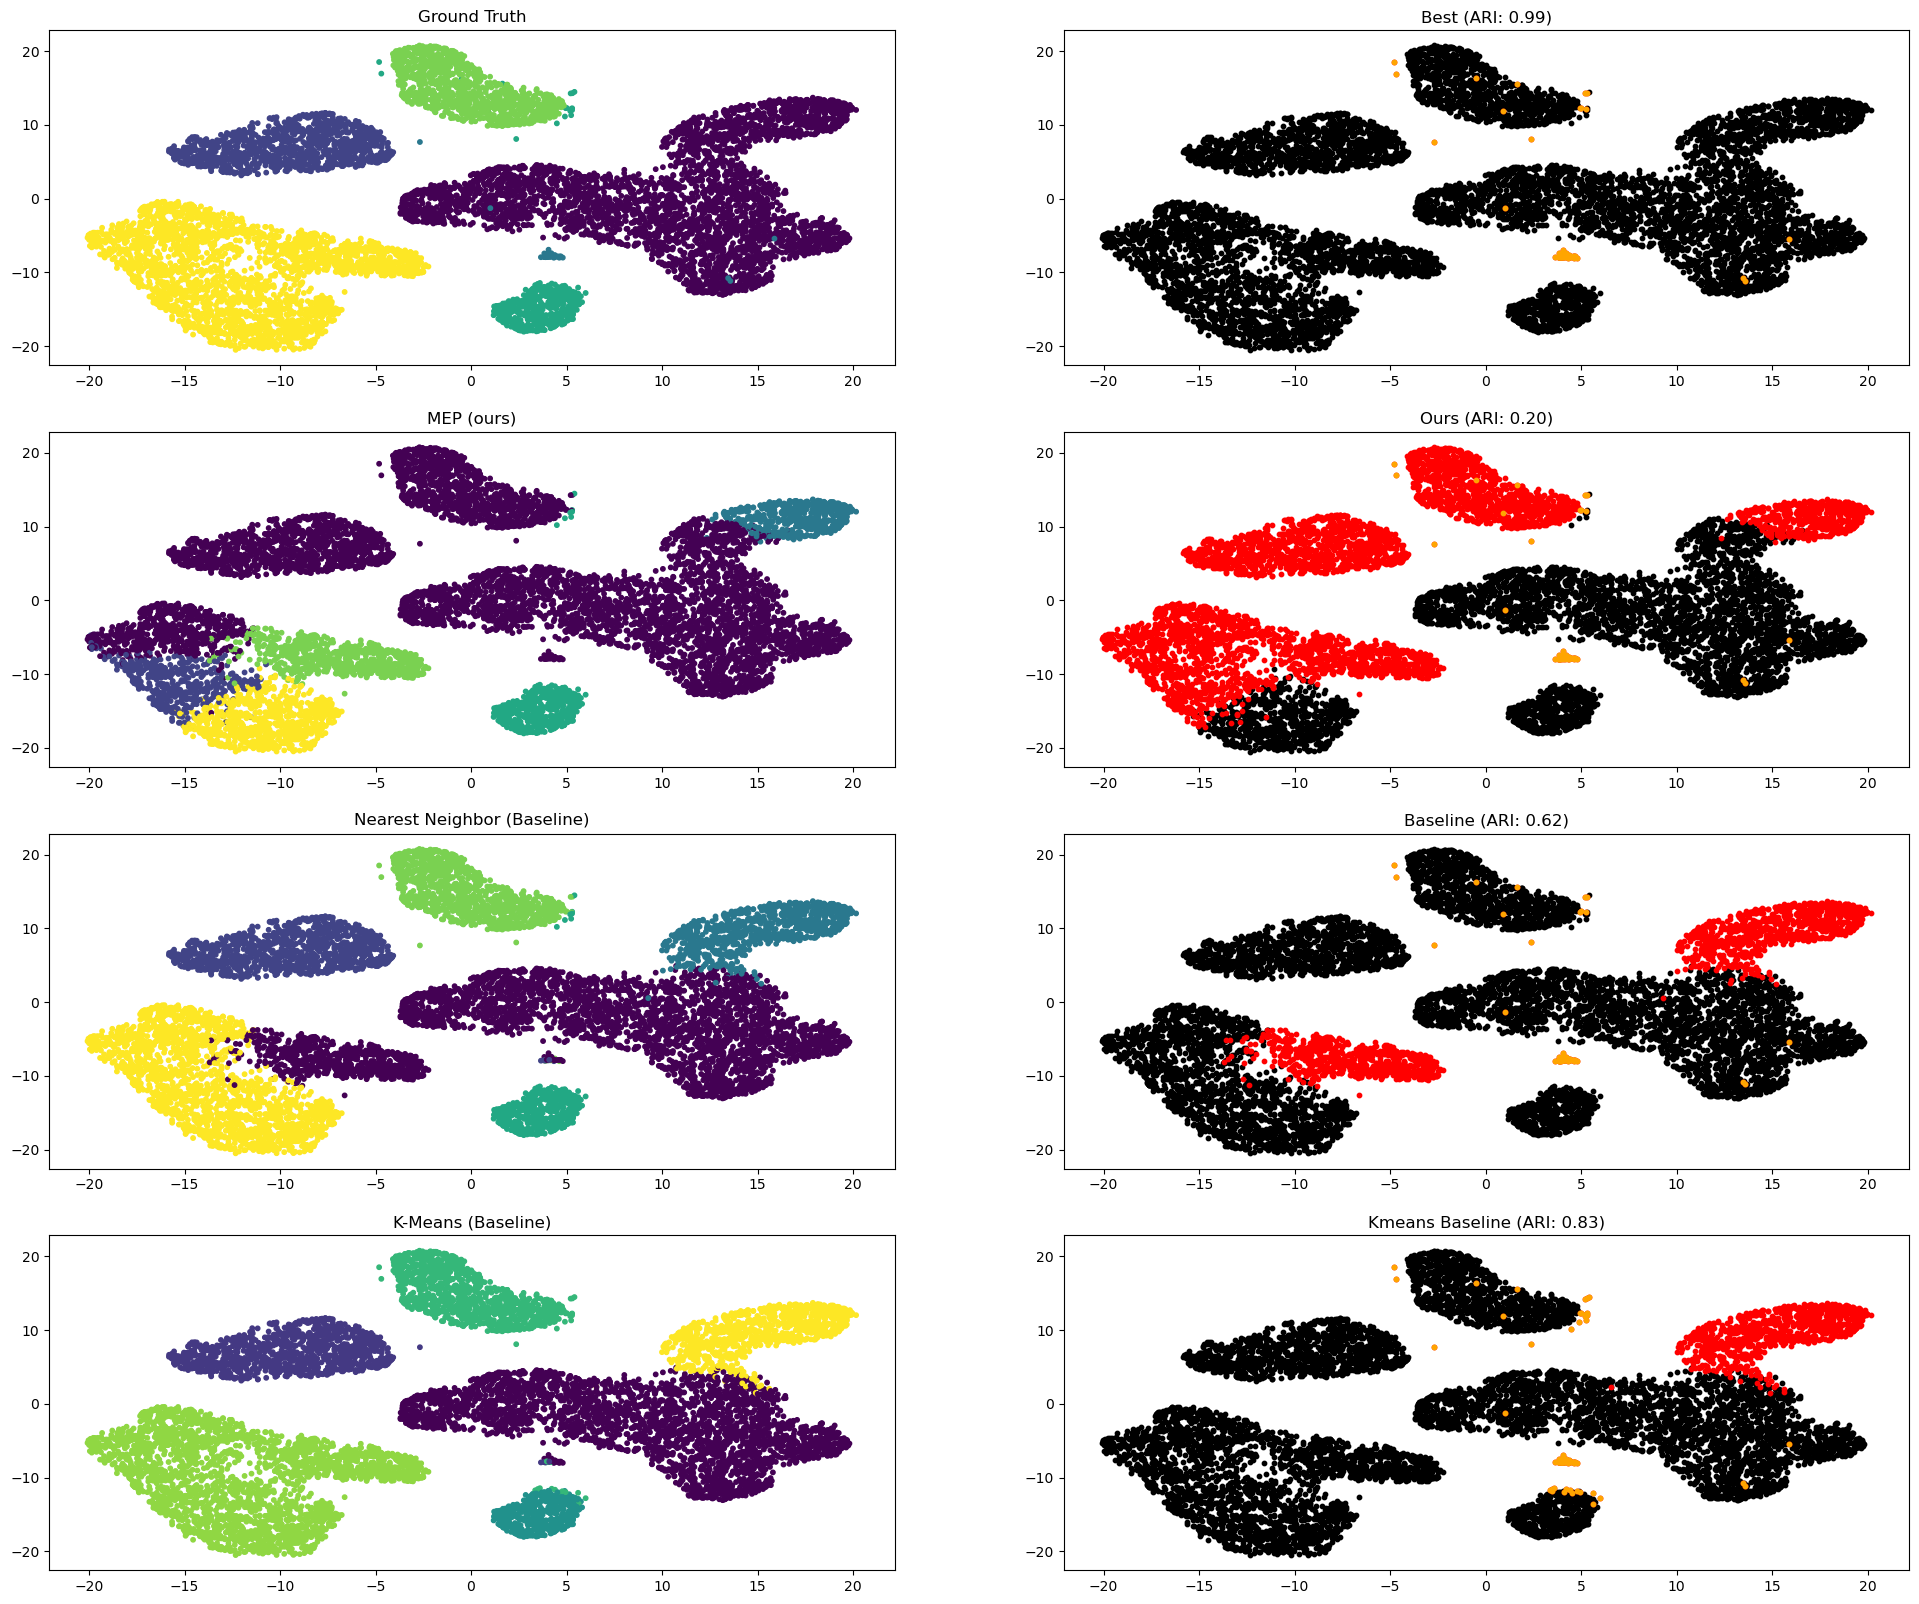

In [122]:
fig, axs = plt.subplots(4, 2, figsize=(24, 20))

# ground truth
axs[0,0].scatter(transformed_points[:,0], transformed_points[:,1], c=y, cmap='viridis', s=10)
axs[0,0].set_title("Ground Truth")
y_best = corc.utils.best_possible_labels_from_overclustering(y,tmm_model.mixture_model.predict(X))
correct_mask = (y == y_best)
ari_best = sklearn.metrics.adjusted_rand_score(y,y_best)
plot_mask(transformed_points,correct_mask,correct_mask,axs[0,1],title=f"Best (ARI: {ari_best:.2f})")
print("GT done.")

# ours
y_pred = tmm_model.predict_with_target(X,len(np.unique(y)))
y_pred = corc.utils.reorder_colors(y_pred,y)
ari_neb = sklearn.metrics.adjusted_rand_score(y,y_pred)
axs[1,0].scatter(transformed_points[:,0], transformed_points[:,1], c=y_pred, cmap='viridis', s=10)
axs[1,0].set_title("MEP (ours)")
plot_mask(transformed_points,(y == y_pred), correct_mask, axs[1,1], title=f"Ours (ARI: {ari_neb:.2f})")
print("ours done.")

# baseline
y_pred_full = tmm_model.mixture_model.predict(X)
y_baseline = predict_by_joining_closest_clusters(centers=tmm_model.mixture_model.centers,y_pred=y_pred_full,num_classes=len(np.unique(y)))
y_baseline = corc.utils.reorder_colors(y_baseline,y)
ari_baseline = sklearn.metrics.adjusted_rand_score(y,y_baseline)
axs[2,0].scatter(transformed_points[:,0], transformed_points[:,1], c=y_baseline, cmap='viridis', s=10)
axs[2,0].set_title("Nearest Neighbor (Baseline)")
plot_mask(transformed_points,(y == y_baseline), correct_mask, axs[2,1],title=f"Baseline (ARI: {ari_baseline:.2f})")
print("Closest done.")

# kmeans
kmeans = sklearn.cluster.KMeans(n_clusters=15).fit(X)
centers = kmeans.cluster_centers_
kmeans_pred = kmeans.predict(X)
kmeans_pred_joined = predict_by_joining_closest_clusters(
    centers=centers,
    y_pred=kmeans_pred,
    num_classes=len(np.unique(y))
)
kmeans_pred_joined = corc.utils.reorder_colors(kmeans_pred_joined,y)
ari_kmeans = sklearn.metrics.adjusted_rand_score(y, kmeans_pred_joined)
axs[3,0].scatter(transformed_points[:,0], transformed_points[:,1], c=kmeans_pred_joined, cmap='viridis', s=10)
axs[3,0].set_title("K-Means (Baseline)")
best_mask_kmeans = (y == corc.utils.best_possible_labels_from_overclustering(y,kmeans_pred))
plot_mask(transformed_points,(y == kmeans_pred_joined), best_mask_kmeans, axs[3,1],title=f"Kmeans Baseline (ARI: {ari_kmeans:.2f})")
print("kmeans done.")

plt.savefig(f"../figures/join_strategies_{dataset_name}_{X.shape[-1]}.pdf")

joined 1 and 11 (both now in class 1)
joined 1 and 10 (both now in class 1)
joined 10 and 11 (both now in class 1)
joined 0 and 9 (both now in class 0)
joined 4 and 13 (both now in class 4)


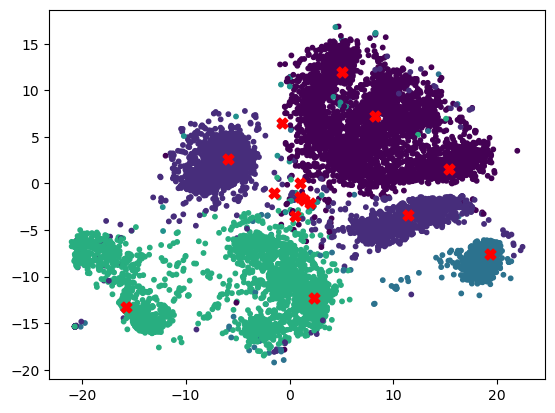

In [142]:
# just kmeans
kmeans = sklearn.cluster.KMeans(n_clusters=15).fit(X)
centers = kmeans.cluster_centers_
kmeans_pred = kmeans.predict(X)
kmeans_pred_joined = predict_by_joining_closest_clusters(
    centers=centers,
    y_pred=kmeans_pred,
    num_classes=10
)
centers_2d = corc.utils.snap_points_to_TSNE(centers,X, transformed_points)

kmeans_pred_joined = corc.utils.reorder_colors(kmeans_pred_joined,y)
ari_kmeans = sklearn.metrics.adjusted_rand_score(y, kmeans_pred_joined)
plt.scatter(transformed_points[:,0], transformed_points[:,1], c=kmeans_pred_joined, cmap='viridis', s=10)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c="red", marker="X", s=60)
# plt.set_title("K-Means (Baseline)")
# best_mask_kmeans = (y == corc.utils.best_possible_labels_from_overclustering(y,kmeans_pred))
# plot_mask(transformed_points,(y == kmeans_pred_joined), best_mask_kmeans, axs[3,1],title=f"Kmeans Baseline (ARI: {ari_kmeans:.2f})")
# print("kmeans done.")
# plt.gcf

In [136]:
np.unique(kmeans_pred,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int32),
 array([   3, 1631, 1241, 1053,    1, 1642,    1,  577,    1,  509, 1153,
         600,  891,  692,    5]))